In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import numpy as np
import gzip
import os
from os.path import basename
import glob
import time
import cv2
import pandas as pd
import random
from PIL import Image
#import scipy.ndimage
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.misc import imresize
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
#from keras.layers import Dense, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras import backend as K

K.set_image_dim_ordering('th') # Theano dimension ordering in this code

Using TensorFlow backend.


In [2]:
INPUT_PATH = '/Users/adithya/Downloads/machine_learning_project/'
dims = [128, 128] 
img_rows = dims[0]
img_cols = dims[1]
train = sorted(glob.glob(INPUT_PATH + 'train/*.jpg'))
masks = sorted(glob.glob(INPUT_PATH + 'train_masks/*.gif'))
test  = sorted(glob.glob(INPUT_PATH + 'test/*.jpg'))
print('Number of training images: ', len(train), ' Number of corresponding masks: ', len(masks), ' Number of test images: ', len(test))

meta = pd.read_csv(INPUT_PATH + 'metadata.csv')
mask_df = pd.read_csv(INPUT_PATH + 'train_masks.csv')
ids_train = mask_df['img'].map(lambda s: s.split('_')[0]).unique()
print('Length of ids_train ', len(ids_train))

Number of training images:  5088  Number of corresponding masks:  5088  Number of test images:  100064
Length of ids_train  318


In [3]:
mask_df.head()
#'''rle_mask is the run-length encoded version of the training set masks the input for the encoder has to be binary; zeroes and ones.
#I read the encoding output as the pixel number of the first 1 (in the flattened mask) followed by the count of consecutive (uninterupted) series of pixels with value 
#'''

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [4]:
train[0]

'/Users/adithya/Downloads/machine_learning_project/train/00087a6bd4dc_01.jpg'

In [5]:
masks[0]

'/Users/adithya/Downloads/machine_learning_project/train_masks/00087a6bd4dc_01_mask.gif'

In [6]:
test[0]

'/Users/adithya/Downloads/machine_learning_project/test/0004d4463b50_01.jpg'

In [7]:
ids_train[0]

'00087a6bd4dc'

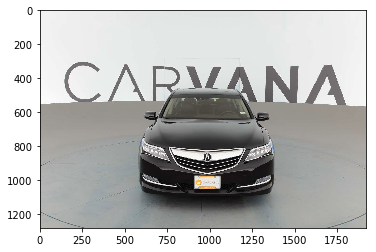

In [8]:
image = cv2.imread(INPUT_PATH + 'train/00087a6bd4dc_01.jpg')
plt.imshow(image)
plt.show()

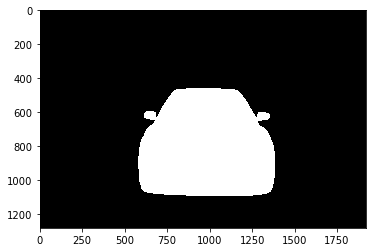

In [9]:
img = Image.open(INPUT_PATH + 'train_masks/00087a6bd4dc_01_mask.gif').convert('RGB')
plt.imshow(img)
plt.show()

In [10]:
# from ecobill:

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)



In [11]:
# this is the U-Net model I encountered in the LUNA16 Challenge
def get_unet():
    inputs = Input((3,img_rows, img_cols))
    conv1 = Conv2D(32, (3, 3), padding="same", activation='relu')(inputs)    
    conv1 = Conv2D(32, (3, 3), padding="same", activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), padding="same", activation='relu')(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation='relu')(conv2)    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), padding="same", activation='relu')(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation='relu')(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation='relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), padding="same", activation='relu')(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation='relu')(conv5)

    up6 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv5), conv4])
    #      Concatenate(axis=3)([residual, upconv])
    conv6 = Conv2D(256, (3, 3), padding="same", activation='relu')(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation='relu')(conv6)

    up7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(128, (3, 3), padding="same", activation='relu')(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation='relu')(conv7)

    up8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(64, (3, 3), padding="same", activation='relu')(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation='relu')(conv8)

    up9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32, (3, 3), padding="same", activation='relu')(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation='relu')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)   #9

    model = Model(inputs=inputs, outputs=conv10)
    #      `Model(inputs=/input_19, outputs=sigmoid.0)`

    #model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef])  #LUNA16
    model.compile(optimizer=Adam(5e-4), loss='binary_crossentropy', metrics=[dice_coef]) #ecobill

    return model



In [12]:
# split the train set into train and validation:
train_images, validation_images = train_test_split(train, train_size=0.8, test_size=0.2)
print('Split into training set with ', len(train_images), ' images and validation set with  ', len(validation_images), ' images')

Split into training set with  4070  images and validation set with   1018  images


In [13]:
#use loading functions from: ecobill

# utility function to convert greyscale images to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img


# generator that we will use to read the data from the directory
def data_gen_small(data_dir, masks, images, batch_size, dims):
        """
        data_dir: where the actual images are kept
        mask_dir: where the actual masks are kept
        images: the filenames of the images we want to generate batches from
        batch_size: self explanatory
        dims: the dimensions in which we want to rescale our images
        
        Image.resize(size, resample=0)

        Returns a resized copy of this image.
        Parameters:	

        size – The requested size in pixels, as a 2-tuple: (width, height).
        resample – An optional resampling filter. This can be one of PIL.Image.NEAREST, 
        PIL.Image.BOX, PIL.Image.BILINEAR, PIL.Image.HAMMING, PIL.Image.BICUBIC or PIL.Image.LANCZOS. 
        If omitted, or if the image has mode “1” or “P”, it is set PIL.Image.NEAREST
        """
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            
            imgs = []
            labels = []
            for i in ix:
                # images
                original_img = cv2.imread(images[i])
                resized_img = imresize(original_img, dims+[3]) #this looks like TensorFlow ordering 
                array_img = resized_img / 255   
                array_img = array_img.swapaxes(0,2)
                imgs.append(array_img)
                #imgs is a numpy array with dim: (batch size X 128 X 128 X 3)
                
                # masks
                mask_filename = basename(images[i])
                no_extension = os.path.splitext(mask_filename)[0]
                correct_mask = INPUT_PATH + 'train_masks/' + no_extension + '_mask.gif' 
                original_mask = Image.open(correct_mask).convert('L')
                data = np.asarray( original_mask, dtype="int32" )
                resized_mask = imresize(original_mask, dims+[3])
                array_mask = resized_mask / 255
                labels.append(array_mask)
            imgs = np.array(imgs)
            labels = np.array(labels)
            relabel = labels.reshape(-1, dims[0], dims[1], 1)
            yield imgs, relabel.swapaxes(1, 3)



Size of batch:  2
shape of img  (2, 3, 128, 128) number dimensions:  3
shape of msk  (2, 1, 128, 128) number dimensions:  3


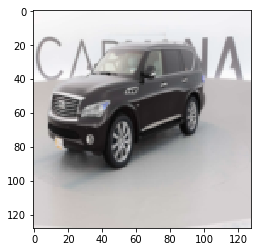

resized up:  (1280, 1918, 3)
resized swapaxes:  (1918, 1280, 3)
resized swapaxes shape[-1]:  3


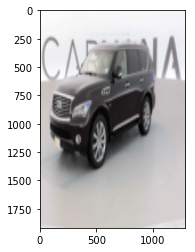

(2, 128, 128, 1)


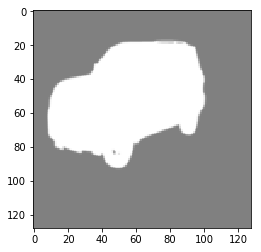

In [14]:
train_gen = data_gen_small(INPUT_PATH + 'train/', masks, train_images, 2, dims) 
img, msk = next(train_gen)
print('Size of batch: ', len(img))
print('shape of img ', img.shape, 'number dimensions: ', img[0].ndim)
print('shape of msk ', msk.shape, 'number dimensions: ', msk[0].ndim)
newshape = img[0].swapaxes(0,2)
plt.imshow(newshape)
plt.show()

#try resize up 

resized_img = imresize(img[0], [1280, 1918]+[3])
print('resized up: ', resized_img.shape)
newshape = resized_img.swapaxes(0,1)
print('resized swapaxes: ', newshape.shape)
print('resized swapaxes shape[-1]: ', newshape.shape[-1])

plt.imshow(newshape)
plt.show()

newshape = msk.swapaxes(1,3)
print(newshape.shape)
plt.imshow(grey2rgb(newshape[0]), alpha=0.5)
plt.show()

In [15]:
# create an instance of a validation generator:
validation_gen = data_gen_small(INPUT_PATH + 'train/', masks, validation_images, 4, dims) 

In [16]:
# define and compile the model
model = get_unet()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 128, 128)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 128, 128)  896         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 32, 128, 128)  9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 32, 64, 64)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [17]:
# fit the model and check dice_coef on validation data at end of each epoch
model.fit_generator(train_gen, steps_per_epoch=50, epochs=1, validation_data=validation_gen, validation_steps=50)

Epoch 1/1
50/50 [==============================] - 297s - loss: 0.4504 - dice_coef: 0.3452 - val_loss: 0.7108 - val_dice_coef: 0.3317


In [35]:
# lets look at one of the predicted masks
img, msk = next(validation_gen)
predicted_mask = model.predict(img)
predicted_mask.shape

(4, 1, 128, 128)

In [18]:
a = []

In [63]:
a.append(1)

In [19]:
a[0]

IndexError: list index out of range

In [43]:
a = [[] for i in range(2)] 

In [44]:
a[0].append(1)

In [45]:
a[0].append(2)

In [46]:
a[1].append(3)

In [47]:
a

[[1, 2], [3]]

In [49]:
from numpy import array
ar = array(a)

import csv

fl = open('/Users/adithya/Downloads/machine_learning_project/filename.csv', 'w')

writer = csv.writer(fl)
writer.writerow(['label1', 'label2', 'label3']) #if needed
for values in ar:
    writer.writerow(values)

fl.close()

In [50]:
img, msk = next(validation_gen)

In [57]:
predicted_mask = model.predict(img)

In [107]:
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

In [ ]:
directory = '/Users/adithya/Downloads/machine_learning_project/test'
i = 0
images = []
imgs = []
labels = []
b = []
for filename in os.listdir(directory):
    if(i<100):
        images.append(filename)
        img, msk = next(validation_gen)
        predicted_mask = model.predict(img)
        xyz = rle_encode(predicted_mask)
        b.append(xyz)
        

In [106]:
directory = '/Users/adithya/Downloads/machine_learning_project/test'
i = 0
images = []
imgs = []
labels = []
for filename in os.listdir(directory):
    if(i<1):
        images.append(filename)
        original_img = cv2.imread(images[i])
        #resized_img = cv2.resize(original_img, dims+[3]) #this looks like TensorFlow ordering 
        #array_img = resized_img / 255   
        #array_img = array_img.swapaxes(0,2)
        #imgs.append(array_img)
        #i = i+1
#imgs = np.array(imgs)

error: /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/imgwarp.cpp:3483: error: (-215) ssize.width > 0 && ssize.height > 0 in function resize


In [91]:
org = cv2.imread(images[2])

In [96]:
res = cv2.resize(org,(128,128),cv2.INTER_LINEAR)

error: /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/imgwarp.cpp:3483: error: (-215) ssize.width > 0 && ssize.height > 0 in function resize


In [ ]:
res2 = im

In [59]:
xyz = rle_encode(predicted_mask)

In [60]:
xyz

array([    2,     1,     4, ..., 65534,     1, 65536])

In [61]:
images[1]

NameError: name 'images' is not defined

In [ ]:
for(i=0;i<500):
    img, msk = next(validation_gen)
    predicted_mask = model.predict(img)
    b[i].append(img)
    
    